In [1]:
!nvidia-smi

Fri May 31 07:01:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2  # Assuming binary classification (fracture vs. non-fracture)
EPOCHS = 50
LEARNING_RATE = 0.0001

# Set the paths to your dataset directories
train_dir = '/content/drive/MyDrive/brone fracture train test val/train'
validation_dir = '/content/drive/MyDrive/brone fracture train test val/val'
test_dir = '/content/drive/MyDrive/brone fracture train test val/test'
save_path = "/content/drive/MyDrive/Model details/model.h5"
overall_csv_filepath = "/content/drive/MyDrive/Model details/model.csv"
overall_h5_filepath = "/content/drive/MyDrive/Model details/model.h5"

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')

test_generator = validation_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

# Build the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks = [ModelCheckpoint(filepath=overall_h5_filepath, monitor='val_accuracy', save_best_only=True)]

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // BATCH_SIZE,
                    callbacks=callbacks)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // BATCH_SIZE)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save model details to CSV
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv(overall_csv_filepath, index=False)


Found 6654 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 1893 images belonging to 2 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 0.8529 - accuracy: 0.5168

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 1907s 9s/step - loss: 0.8529 - accuracy: 0.5168 - val_loss: 0.6784 - val_accuracy: 0.5043
Epoch 2/50
207/207 [==============================] - 120s 582ms/step - loss: 0.7739 - accuracy: 0.5276 - val_loss: 0.6692 - val_accuracy: 0.6142
Epoch 3/50
207/207 [==============================] - 117s 565ms/step - loss: 0.7347 - accuracy: 0.5423 - val_loss: 0.6882 - val_accuracy: 0.5496
Epoch 4/50
207/207 [==============================] - 115s 556ms/step - loss: 0.7101 - accuracy: 0.5355 - val_loss: 0.6708 - val_accuracy: 0.5916
Epoch 5/50
207/207 [==============================] - 115s 556ms/step - loss: 0.6947 - accuracy: 0.5352 - val_loss: 0.6831 - val_accuracy: 0.5603
Epoch 6/50
207/207 [==============================] - 117s 567ms/step - loss: 0.6819 - accuracy: 0.5491 - val_loss: 0.6728 - val_accuracy: 0.5399
Epoch 7/50
207/207 [==============================] - 115s 554ms/step - loss: 0.6835 - accuracy: 0.5421 - val_loss: 0.6732 - val_accuracy

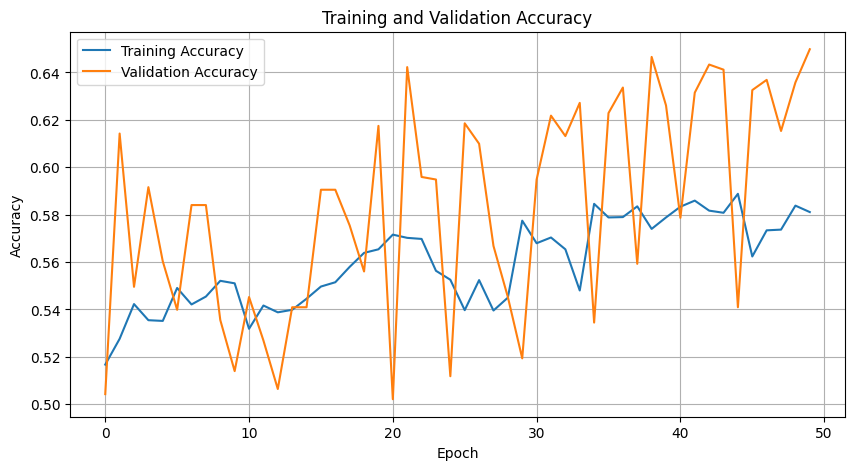

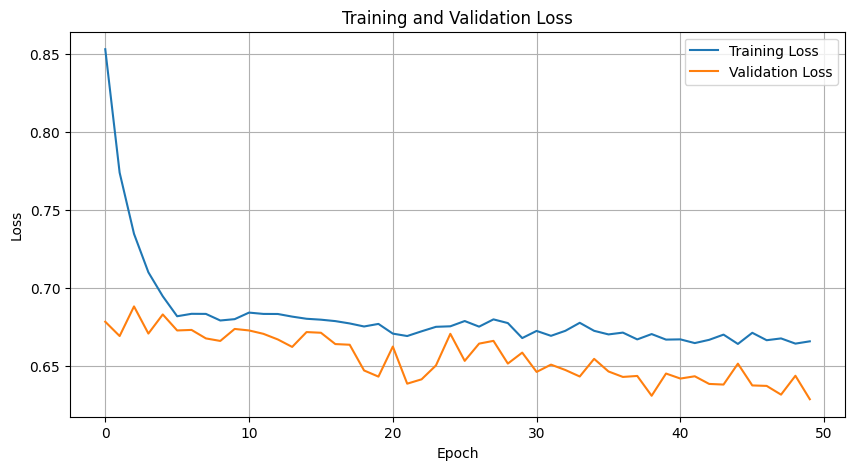

60/60 [==============================] - 16s 257ms/step - loss: 0.6195 - accuracy: 0.6445
Test Loss: 0.6194896697998047
Test Accuracy: 0.6444796323776245


In [3]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data and visualize test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


60/60 [==============================] - 11s 160ms/step


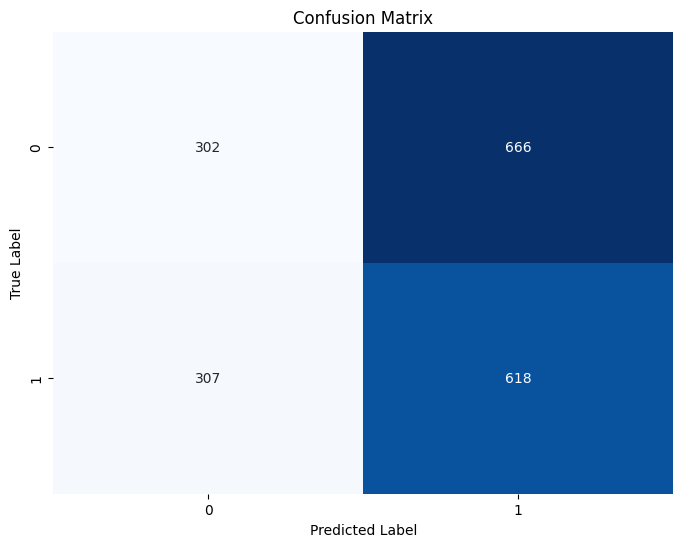

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test generator
true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [6]:
from sklearn.metrics import classification_report

# Reset the test generator and make predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.n // BATCH_SIZE + 1)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes[:len(y_pred)]

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

# Print the classification report
print("\nClassification Report:\n")
print(report)


60/60 [==============================] - 11s 183ms/step

Classification Report:

              precision    recall  f1-score   support

    fracture       0.51      0.32      0.40       968
non fracture       0.49      0.68      0.57       925

    accuracy                           0.50      1893
   macro avg       0.50      0.50      0.48      1893
weighted avg       0.50      0.50      0.48      1893



60/60 [==============================] - 10s 165ms/step


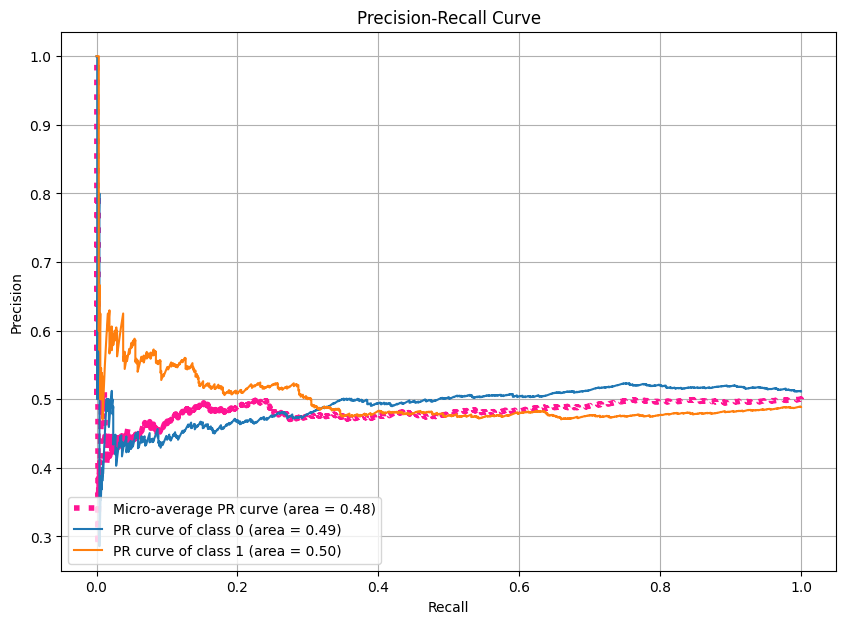

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get predictions for test data
predictions = model.predict(test_generator)
true_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test generator
true_labels = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    true_labels.extend(np.argmax(labels, axis=1))

# Convert true_labels to integer array
true_labels = np.array(true_labels)

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve((true_labels == i).astype(int), predictions[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Compute micro-average precision-recall curve and PR AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(np.eye(NUM_CLASSES)[true_labels].ravel(), predictions.ravel())
pr_auc["micro"] = auc(recall["micro"], precision["micro"])

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall["micro"], precision["micro"], label='Micro-average PR curve (area = {0:0.2f})'.format(pr_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
for i in range(NUM_CLASSES):
    plt.plot(recall[i], precision[i], label='PR curve of class {0} (area = {1:0.2f})'.format(i, pr_auc[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


1/1 [==============================] - 1s 874ms/step


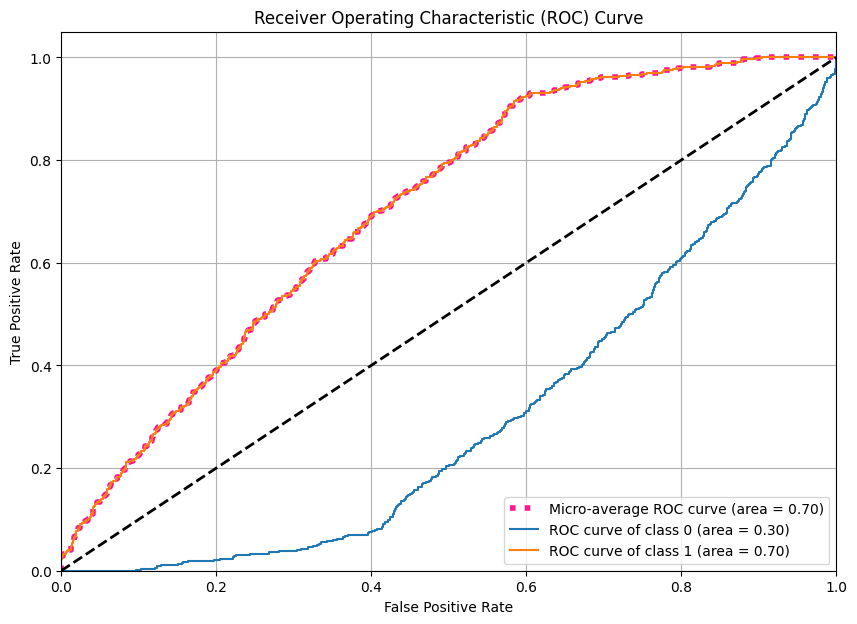

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions for test data
predictions = []
true_labels = []
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    batch_predictions = model.predict(x_batch)
    predictions.extend(batch_predictions)
    true_labels.extend(np.argmax(y_batch, axis=1))

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = predictions.shape[1]
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels, predictions[:, 1],pos_label=1)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
